# TensorFlow 2.0 alpha - Image to Image Translation using Conditional GANs
### Using the CMP Facade Database
### This technique can be used to:
* Colorize black/white images
* Conversion of Google Maps to Goole Earth
* Convert building facades to real buildings (this exercise)

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt

from IPython.display import clear_output

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the Data
#### Training data will have Random Jittering - image resized to 286x286
#### Training data will have Random Mirroring - image flipped horizontally

In [3]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 32s 1us/step


In [4]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    
    w = w // 2 
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

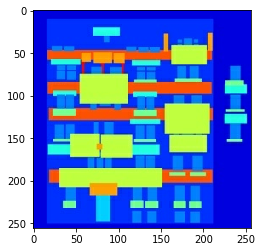

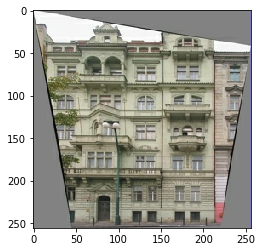

In [6]:
inp, re = load(PATH+'train/100.jpg')

# casting to int - for matplotlib to show the image

plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [7]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                 method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT,
                                                             IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [10]:
# normalize images to [-1, 1]

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    
    return input_image, real_image

In [11]:
# resize to 286x286x3
# randomly crop to 256x256x3
# random mirroring

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    input_image, real_image = random_crop(input_image, real_image)
    
    if tf.random.uniform(()) > 0.5 :
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

#### Random Jittering (seen below)
* Resize image to larger height and width
* Randomly crop it to original size
* Randomly flip it horizontally

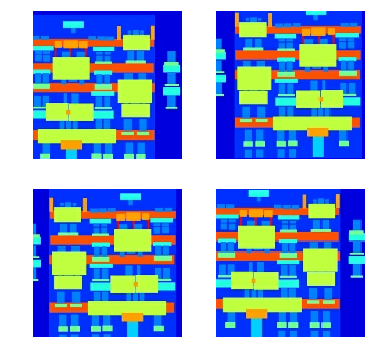

In [12]:
plt.figure(figsize=(6,6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

In [13]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [14]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                    IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

## Input Pipeline

In [15]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train,
                                 num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

In [17]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')

# shuffling so each epoch generates a different image to predict/display model progress

# SHOULD THIS TOP ONE BE TRAIN_DATASET OR TEST

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [18]:
# IF ERRORS LOOKS ABOVE - OTHERWISE DELETS THIS AND MESSAGE IN ABOVE

## Build the Generator
#### Architecture is a Modified U-Net
* Each block in the Encoder - Conv -> Batchnorm -> Leaky ReLU
* Each block in the Decoder - Transposed Conv -> Batchnorm -> Dropout (1st 3 blocks) -> ReLU
* There are skip connections between the Encoder and Decoder - as in U-Net

In [19]:
OUTPUT_CHANNELS = 3

In [20]:
def downsample(filters, size, apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                     kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [21]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))

print(down_result.shape)

(1, 128, 128, 3)


In [28]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                              padding='same',
                                              kernel_initializer=initializer,
                                              use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [29]:
up_model = upsample(3, 4)
up_result = up_model(down_result)

print(up_result.shape)

(1, 256, 256, 3)


In [30]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides=2,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')
    
    concat = tf.keras.layers.Concatenate()
    
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs
    
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

W0429 22:43:25.411862 140736985473984 image.py:663] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


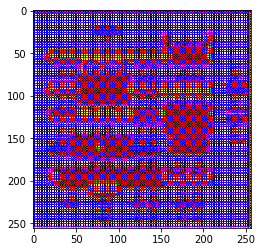

In [31]:
generator = Generator()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

## Build a Discriminator
#### Discriminator is a PatchGAN
* Each block in Discriminator - Conv -> BatchNorm -> Leaky ReLU
* Output shape after last layer is (batch_size, 30, 30 1)
* Each 30x30 Output patch classifies a 70x70 portion of the Input image (PatchGAN architecture)

#### Discriminator receives 2 inputs
* Input image and Target image - should classify as Real
* Input image and Generated image (from Generator) - should classify as Fake
* Concatenate these 2 Inputs together - tf.concat([inp, tar], axis=-1) 

In [32]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    
    x = tf.keras.layers.concatenate([inp, tar])
    
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                 kernel_initializer=initializer,
                                 use_bias=False)(zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                 kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

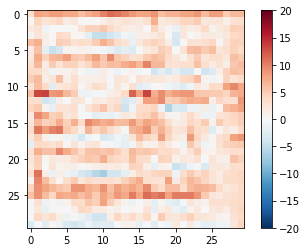

In [33]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)

plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Define the Loss Functions and the Optimizer
#### Discriminator Loss
* Loss Function takes 2 inputs - real images, generated images
* Real_loss - sigmoid cross entropyloss of real images - array of 1s
* Generated_loss - sigmoid cross entropy loss of generated images - array of 0s
* Total_loss - sum of these 2

#### Generator Loss
* Sigmoid cross entropy loss of generated images - array of 1s
* L1 loss (MAE) - between the generated image and the target image - can be included
* This allows generated image to become structurally similar to target image
* Total_generated_loss - gan_loss + LAMBDA * L1_loss

In [34]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [36]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # mean absolute error
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints - Object-based saving

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## Training
#### Iterate over the dataset - Generator gets input image, giving output image
#### Discriminator receives the input image & generated image as its 1st input - 2nd input is input and target images
#### Generator and Discriminator Loss are calculated
#### Calulate Gradients of the loss (with respect to generator and discriminator variables(inputs)) - Apply them to the Optimizer

## Generate Images
#### Pass images from the Test dataset to the Generator - translating input image into expected output
#### Plot the Predictions

In [41]:
EPOCHS = 1

In [42]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        
        # get pixel value between [0,1] 
        
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.show()

In [47]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
    generator_gradients = gen_tape.gradient(gen_loss,
                                           generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                           generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                               discriminator.trainable_variables))

In [50]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        for input_image, target in dataset:
            train_step(input_image, target)
        
        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)
         
        # saving checkpoint every 20 epochs
        
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

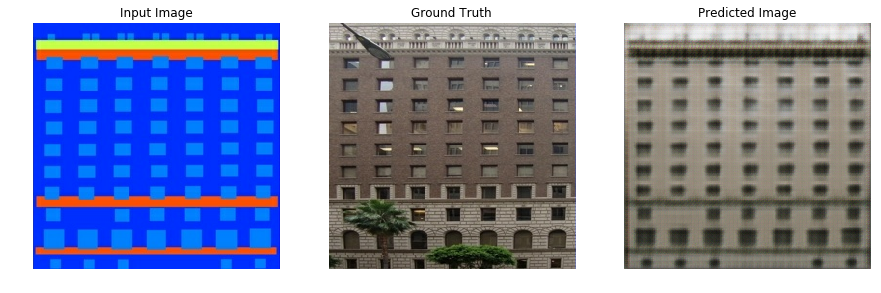

Time taken for epoch 1 is 985.123969078064 sec



In [51]:
train(train_dataset, EPOCHS)

#### Increase the Epochs for better results
## Restore from the latest Checkpoint and Test with Code below

In [ ]:
!ls {checkpoint_dir}

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for inp, tar in test_dataset:
    generate_images(generator, inp, tar)